In [341]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [342]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

device

device(type='cpu')

In [343]:
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [361]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [432]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# download flowers dataset from torchvision and transform the images to 32x32 gray scale images with 1 color channel
flowers_ds = torchvision.datasets.Flowers102(root='data/', split='train', transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(image_size),
        transforms.Grayscale(nc),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5], std = [0.5])
    ]), download=True)

In [398]:

batch_size = 16

# Number of workers for dataloader
workers = 2

# create instance of dataloader flowers_dl
flowers_dl = torch.utils.data.DataLoader(flowers_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

len(flowers_dl)

64

In [399]:
# check the shape of the images in the first batch of data
images, labels = next(iter(flowers_dl))

images.shape


torch.Size([16, 1, 32, 32])

In [427]:
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

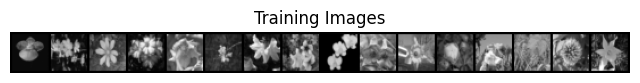

In [401]:
# Plot some training images
real_batch = next(iter(flowers_dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:32], nrow=16, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [405]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    print(nn.init.normal_)

In [404]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z (nz * 1 * 1), going into a convolution
            nn.ConvTranspose2d( in_channels=nz, out_channels=ngf * 2, kernel_size= 8, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # input to layer below - 64 * 8 * 8
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # input to layer below - 32 * 16 * 16
            nn.ConvTranspose2d( in_channels=ngf, out_channels=nc, kernel_size=2, stride = 2, padding = 0, bias=False),
            
            # input to layer below - 1 * 32 * 32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# create and test the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

noise = torch.randn(batch_size, nz, 1, 1)

G_out = netG(noise)
print(G_out.shape)

<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): Tanh()
  )
)
torch.Size([16, 1, 32, 32])


In [406]:
def display_image_grid(images: torch.Tensor, nrow: int):
    print(images.shape)
    image_grid = make_grid(images)
    print(image_grid.shape)
    image_grid = image_grid.permute(1,2,0)
    image_grid = image_grid.cpu().numpy()
    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29488114..0.44011924].


torch.Size([16, 1, 32, 32])
torch.Size([3, 70, 274])
torch.Size([70, 274, 3])
(70, 274, 3)


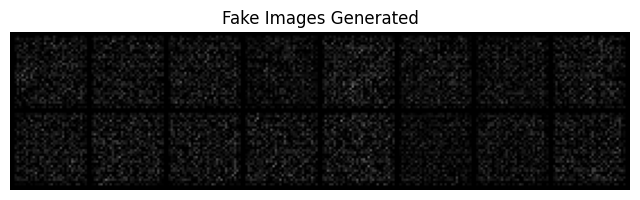

In [407]:
z = torch.randn(batch_size, nz, 1, 1, device=device)

sample_gen_output = netG(z)
print(sample_gen_output.shape)
image_grid = make_grid(sample_gen_output)
print(image_grid.shape)
image_grid = image_grid.permute(1,2,0)
print(image_grid.shape)
image_grid = image_grid.cpu().numpy()
print(image_grid.shape)
# display_image_grid(sample_gen_output, nrow=batch_size)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images Generated")
plt.imshow(image_grid)
plt.xticks([])
plt.yticks([])
plt.show()
plt.close()

In [408]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 32 x 32``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 8 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
# print(netD)


noise = torch.randn(batch_size, nz, 1, 1)

G_out = netG(noise)
print(G_out.shape)
D_out = netD(G_out)
print(D_out.shape)



<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 1, 1])


In [409]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
<function normal_ at 0x12b532340>
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): 

In [410]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [411]:
img_list = []
G_losses = []

iters = 0
print("Starting Generator Training Loop...")

# set generator in training mode and descriminator in eval mode
netG.train()
netD.eval()

for epoch in range(num_epochs):
  for i, real_images in enumerate(flowers_dl, 0):
    # reset generator gradients to zero for next batch
    netG.zero_grad()

    # pass noise vector through generator to generate fake images
    noise = torch.randn(real_images[0].to(device).size(0), nz, 1, 1, device=device)
    fake_images = netG(noise)

    # pass fake_images through descriminator
    D_out_fake = netD(fake_images.detach()).view(-1)

    # computing loss for a generator - maximize the probability that fakes are identified as real
    real_labels = torch.full((real_images[0].to(device).size(0),), real_label, dtype=torch.float, device=device)
    G_loss = criterion(D_out_fake, real_labels)
    G_losses.append(G_loss.item())

    # compute gradients
    G_loss.backward()
    D_G_z2 = D_out_fake.mean().item()

    # update gradients
    optimizerG.step()

    if i % 50 == 0:
        print(' Epoch:%d  Batch:%d  G_loss: %.4f D_G_z2: %.4f'
                  % (epoch, i, G_loss.item(), D_G_z2))
    
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(flowers_dl)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))    
    iters += 1

Starting Generator Training Loop...
 Epoch:0  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:0  Batch:50  G_loss: 0.6932 D_G_z2: 0.5000
 Epoch:1  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:1  Batch:50  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:2  Batch:0  G_loss: 0.6932 D_G_z2: 0.5000
 Epoch:2  Batch:50  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:3  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:3  Batch:50  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:4  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:4  Batch:50  G_loss: 0.6932 D_G_z2: 0.5000
 Epoch:5  Batch:0  G_loss: 0.6932 D_G_z2: 0.5000
 Epoch:5  Batch:50  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:6  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:6  Batch:50  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:7  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:7  Batch:50  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:8  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:8  Batch:50  G_loss: 0.6932 D_G_z2: 0.5000
 Epoch:9  Batch:0  G_loss: 0.6931 D_G_z2: 0.5000
 Epoch:9  Batch:50  G_lo

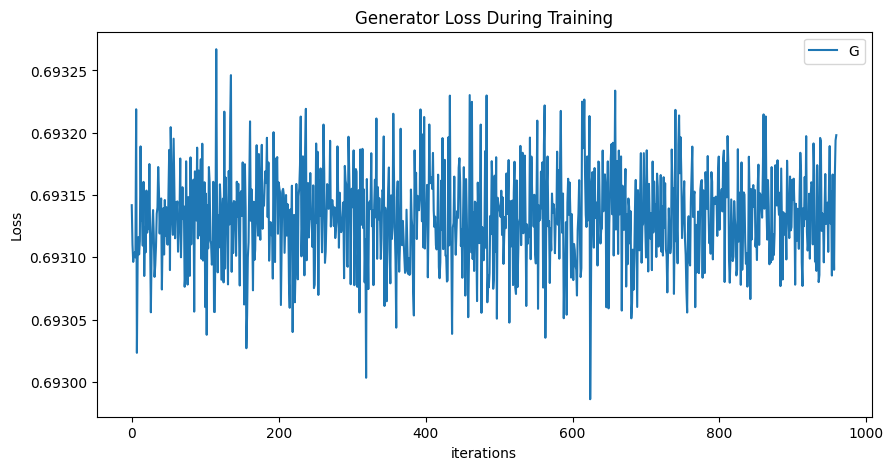

In [412]:
plt.figure(figsize=(10, 5))
plt.title('Generator Loss During Training')
plt.plot(G_losses, label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

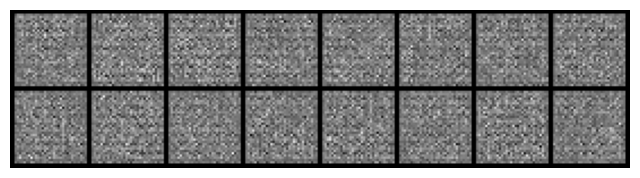

In [413]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

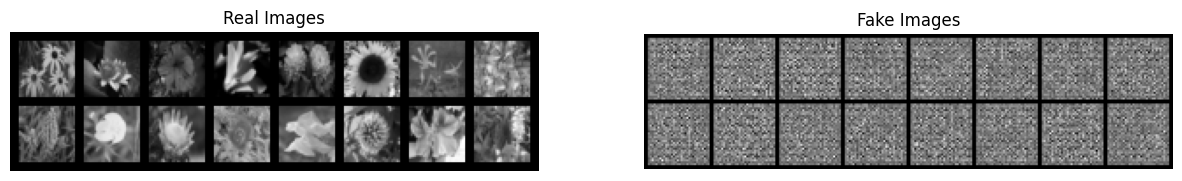

In [414]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(flowers_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [415]:

# Training Descriminator Standalone

# Lists to keep track of progress
img_list = []
D_out_list = []
D_losses = []
iters = 0

print("Starting Descriminator Training Loop...")

# set descriminator in training mode and generator in eval mode
netD.train()
netG.eval()

for epoch in range(num_epochs):
    for i, real_images in enumerate(flowers_dl, 0):
        # reset descriminator gradients to zero for every new batch
        netD.zero_grad()

        ## training discriminator with real images ##
        #1 pass real_images through discriminator
        real_img_device = real_images[0].to(device)
        batch_size = real_img_device.size(0)
        D_out_real = netD(real_img_device).view(-1)
        #2 calculate descriminator loss for real images
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        D_loss_real = criterion(D_out_real, real_labels)
        #3 compute gradients in backward pass
        D_loss_real.backward()
        #4 calculate mean of Descriminator output for real images
        D_real_mean = D_out_real.mean().item()

        ## training discriminator with fake images ##
        #1 pass noise vector through Generator to generate fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        #2 pass fake images through discriminator
        D_out_fake = netD(fake_images.detach()).view(-1)
        #3 calculate mean of Descriminator output for fake images

        D_G_z1 = D_out_fake.mean().item()
        #4 calculate descriminator loss for fake images
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        D_loss_fake = criterion(D_out_fake, fake_labels)
        #5 compute gradients in backward pass
        D_loss_fake.backward()

        # compute total discriminator loss and add it to D_losses list
        D_loss = D_loss_real + D_loss_fake
        D_losses.append(D_loss.item())

        # update the gradients
        optimizerD.step()

        if i % 50 == 0:
            print(' Epoch:%d  Batch:%d  D_loss: %.4f D_G_z1: %.4f, %.4f'
                  % (epoch, i, D_loss.item(), D_real_mean, D_G_z1))
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(flowers_dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                D_out = netD(fake.detach()).view(-1)
                img_list.append(make_grid(fake, padding=2, normalize=True))
                D_out_list.append(D_out)  
                print(f'Descriminator output for fake image {D_out}')    
        iters += 1


Starting Descriminator Training Loop...
 Epoch:0  Batch:0  D_loss: 1.4412 D_G_z1: 0.5319, 0.5363
Descriminator output for fake image tensor([0.5170, 0.6328, 0.6438, 0.4572, 0.2630, 0.3827, 0.4015, 0.5077, 0.5261,
        0.5092, 0.3490, 0.4511, 0.4691, 0.5446, 0.5026, 0.5591])
 Epoch:0  Batch:50  D_loss: 0.0234 D_G_z1: 0.9857, 0.0088
 Epoch:1  Batch:0  D_loss: 0.0200 D_G_z1: 0.9866, 0.0063
Descriminator output for fake image tensor([0.0024, 0.0008, 0.0009, 0.0012, 0.0014, 0.0014, 0.0031, 0.0025, 0.0030,
        0.0019, 0.0019, 0.0013, 0.0017, 0.0036, 0.0015, 0.0045])
 Epoch:1  Batch:50  D_loss: 0.0064 D_G_z1: 0.9958, 0.0022
 Epoch:2  Batch:0  D_loss: 0.0033 D_G_z1: 0.9983, 0.0016
 Epoch:2  Batch:50  D_loss: 0.0022 D_G_z1: 0.9987, 0.0009
 Epoch:3  Batch:0  D_loss: 0.0029 D_G_z1: 0.9981, 0.0010
Descriminator output for fake image tensor([0.0007, 0.0002, 0.0003, 0.0003, 0.0005, 0.0005, 0.0011, 0.0008, 0.0009,
        0.0006, 0.0006, 0.0004, 0.0005, 0.0011, 0.0004, 0.0014])
 Epoch:3  Batch

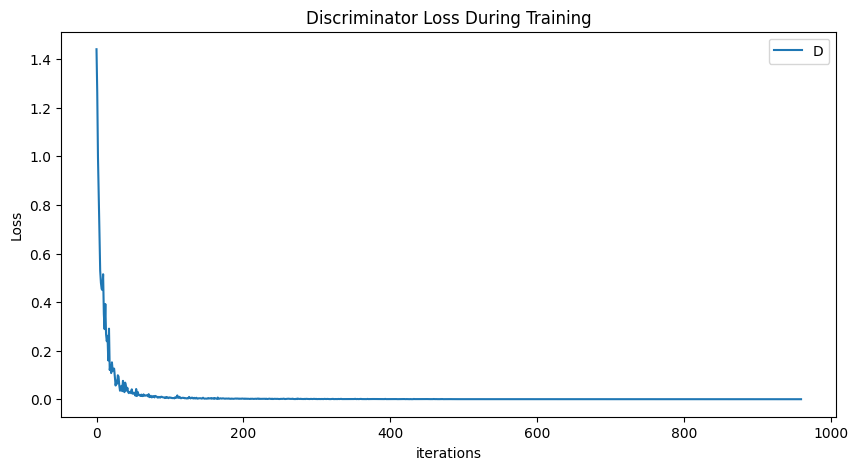

In [416]:
plt.figure(figsize=(10, 5))
plt.title('Discriminator Loss During Training')
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

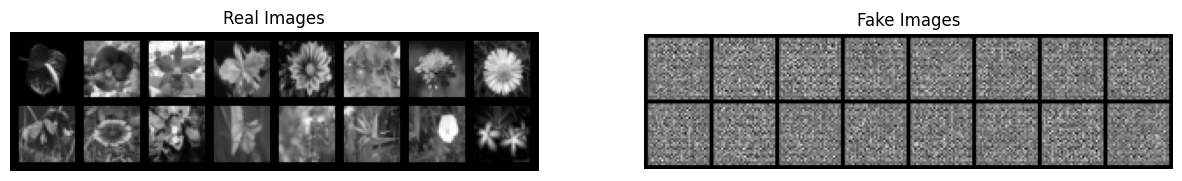

In [417]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(flowers_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [256]:
# D_losses

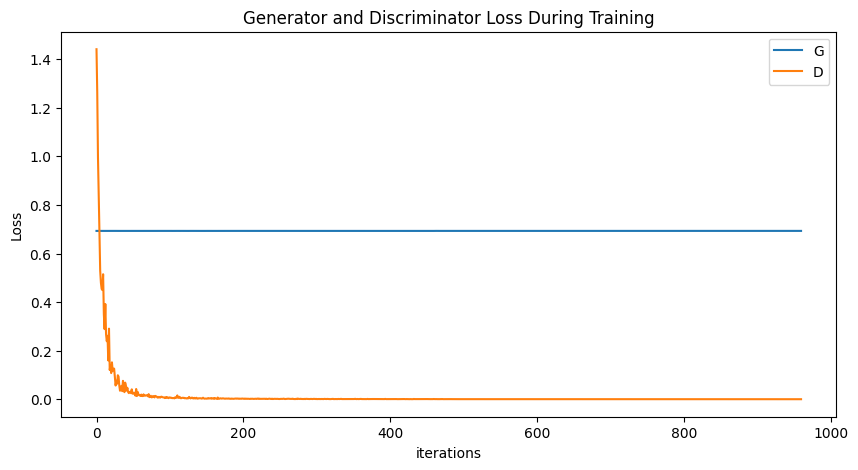

In [418]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [428]:
# Training Descriminator + Generator together

# Lists to keep track of progress
img_list = []
D_losses = []
G_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, real_images in enumerate(flowers_dl, 0):
        netD.zero_grad()

        # print("Training Discriminator with Real Images..")

        # get output of discriminator by passing real_images through it
        real_img_device = real_images[0].to(device)
        batch_size = real_img_device.size(0)
        D_out_real = netD(real_img_device).view(-1)

        # calculate descriminator loss
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        D_loss_real = criterion(D_out_real, real_labels)

        # compute gradients in backward pass
        D_loss_real.backward()

        # calculate mean of Descriminator output for real images
        D_x= D_out_real.mean().item()

        # print("Training Discriminator with Fake Images..")

        # generate a batch of latent vectors of size nz
        latent_vectors = torch.randn(batch_size, nz, 1, 1, device=device)
        # pass the latent noise through Generator to generate fake images
        fake_images = netG(latent_vectors)

        # pass the generated fake images through discriminator and get the output
        D_out_fake = netD(fake_images.detach()).view(-1)

        # calculate mean of Descriminator output for fake images
        D_G_z1 = D_out_fake.mean().item()

        # calculate descriminator loss
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        D_loss_fake = criterion(D_out_fake, fake_labels)

        # compute gradients in backward pass
        D_loss_fake.backward()

        # compute total discriminator loss and add it to D_losses list
        D_loss = D_loss_real + D_loss_fake
        D_losses.append(D_loss.item())

        # update the gradients
        optimizerD.step()

        
        # print("Training Generator....")
        netG.zero_grad()
        out = netD(fake_images).view(-1)
        G_loss = criterion(out, real_labels)
        G_loss.backward()
        G_losses.append(G_loss.item())
        D_G_z2 = out.mean().item()
        optimizerG.step()


        if i % 50 == 0:
            print(' Epoch:%d  Batch:%d  D_loss: %.4f G_loss: %.4f D_x: %.4f D_G_z1: %.4f D_G_z2: %.4f'
                  % (epoch, i, D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(flowers_dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_list.append(make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
 Epoch:0  Batch:0  D_loss: 0.7811 G_loss: 2.0055 D_x: 0.7656 D_G_z1: 0.3269 D_G_z2: 0.1800
 Epoch:0  Batch:50  D_loss: 0.9360 G_loss: 1.9215 D_x: 0.5479 D_G_z1: 0.2204 D_G_z2: 0.1881
 Epoch:1  Batch:0  D_loss: 0.7087 G_loss: 1.9677 D_x: 0.7855 D_G_z1: 0.3559 D_G_z2: 0.1519
 Epoch:1  Batch:50  D_loss: 0.8445 G_loss: 1.4791 D_x: 0.8066 D_G_z1: 0.3965 D_G_z2: 0.2693
 Epoch:2  Batch:0  D_loss: 0.8684 G_loss: 2.0273 D_x: 0.5118 D_G_z1: 0.1161 D_G_z2: 0.1480
 Epoch:2  Batch:50  D_loss: 0.8105 G_loss: 1.6715 D_x: 0.5781 D_G_z1: 0.1911 D_G_z2: 0.2206
 Epoch:3  Batch:0  D_loss: 0.6459 G_loss: 2.0505 D_x: 0.6154 D_G_z1: 0.1175 D_G_z2: 0.1673
 Epoch:3  Batch:50  D_loss: 0.6209 G_loss: 2.0279 D_x: 0.7138 D_G_z1: 0.2031 D_G_z2: 0.2009
 Epoch:4  Batch:0  D_loss: 0.6171 G_loss: 1.6228 D_x: 0.8033 D_G_z1: 0.2904 D_G_z2: 0.2161
 Epoch:4  Batch:50  D_loss: 0.6173 G_loss: 1.6761 D_x: 0.6835 D_G_z1: 0.1634 D_G_z2: 0.2128
 Epoch:5  Batch:0  D_loss: 0.5545 G_loss: 2.3573 D_x: 0.927

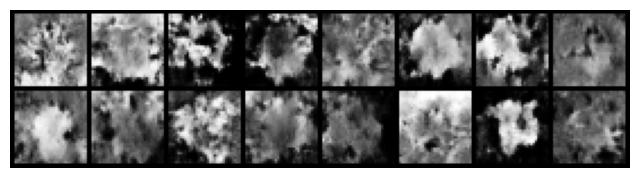

In [429]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

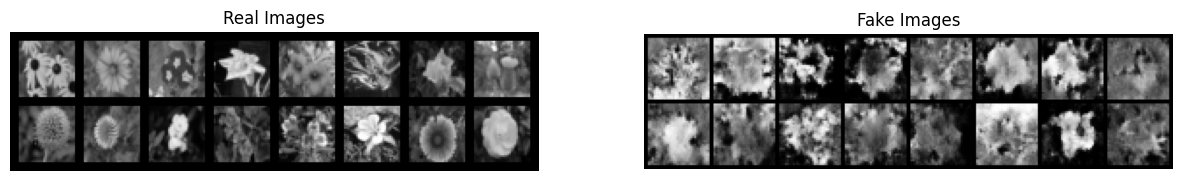

In [430]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(flowers_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

[2.005455493927002, 2.5783703327178955, 1.78177809715271, 1.8331422805786133, 1.8321995735168457, 1.5241485834121704, 1.95763099193573, 2.2865989208221436, 1.5742257833480835, 1.5444368124008179, 1.377363681793213, 2.074084997177124, 1.7463040351867676, 1.875622034072876, 1.8733786344528198, 2.0162949562072754, 1.6463919878005981, 1.734756350517273, 1.7153918743133545, 1.7123469114303589, 1.566645622253418, 2.014061450958252, 1.6076383590698242, 1.238559603691101, 2.141123056411743, 2.0025837421417236, 1.7364630699157715, 2.0191593170166016, 2.1633567810058594, 1.1133993864059448, 1.4765681028366089, 1.703019380569458, 1.5710829496383667, 1.9364961385726929, 1.9623545408248901, 1.7752025127410889, 1.8894935846328735, 2.390096664428711, 1.8345580101013184, 1.3386123180389404, 1.073442816734314, 1.9698803424835205, 2.175053119659424, 1.5084959268569946, 1.4323105812072754, 2.0169153213500977, 2.1249914169311523, 1.4038944244384766, 1.536072015762329, 2.2557477951049805, 1.921493530273437

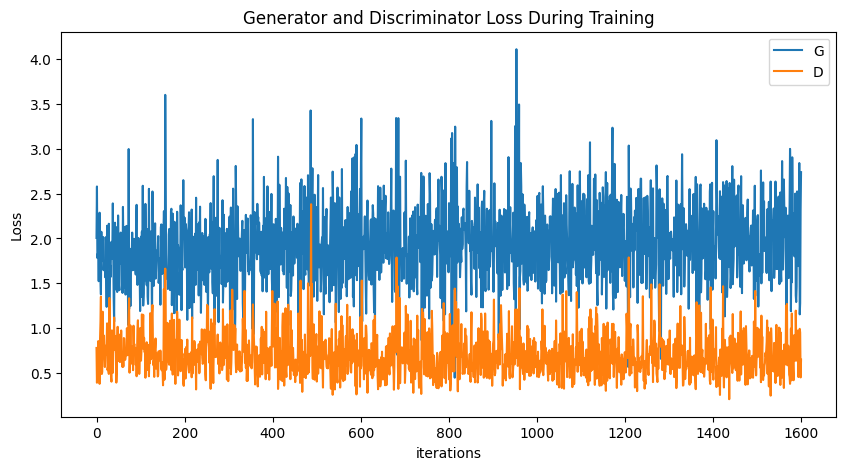

In [433]:
print(G_losses)

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()